# Sheet 5

In [2]:
import os
import pandas as pd

## 2 Logistic regression: an LLM lie detector

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use `add_dataset` multiple times on the same data manager if you want to combine datasets.

In [3]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


In [4]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

## 3 Log-sum-exp and soft(arg)max
### (b)

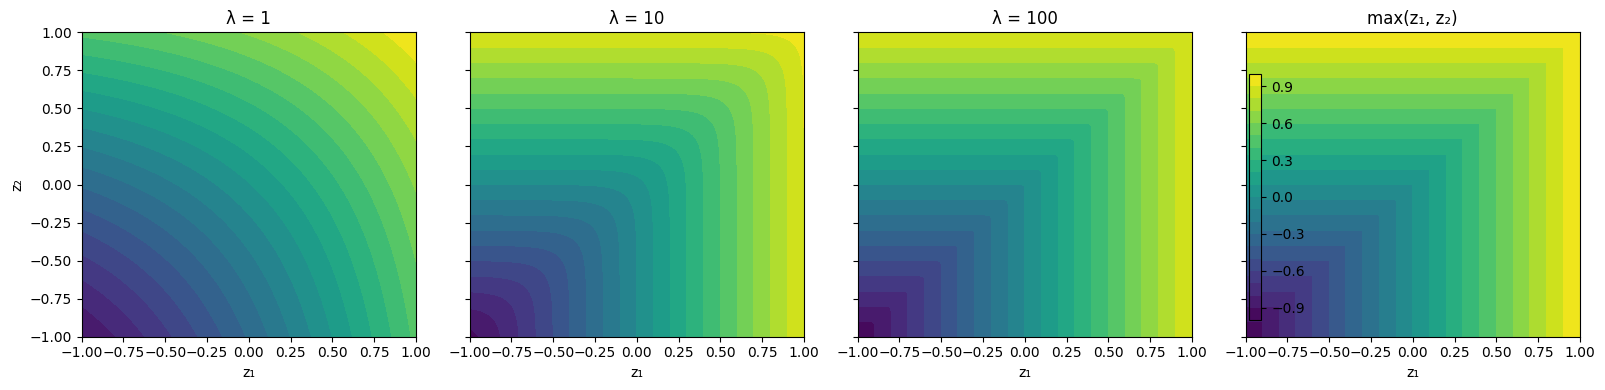

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def lse(z1, z2, lam):
    return (1/lam) * np.log(np.exp(lam*z1) + np.exp(lam*z2))

z = np.linspace(-1, 1, 400)
Z1, Z2 = np.meshgrid(z, z)
lams = [1, 10, 100]

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

for ax, lam in zip(axes[:3], lams):
    cs = ax.contourf(Z1, Z2, lse(Z1, Z2, lam), levels=20)
    ax.set_title(f"λ = {lam}")
    ax.set_xlabel("z₁")
axes[0].set_ylabel("z₂")

cs = axes[3].contourf(Z1, Z2, np.maximum(Z1, Z2), levels=20)
axes[3].set_title("max(z₁, z₂)")
axes[3].set_xlabel("z₁")

fig.colorbar(cs, ax=axes, shrink=0.8)
plt.tight_layout()
plt.show()


### Discussion of the plots of lse

The plots nicely show how the log-sum-exp function increasingly behaves like the max function as λ grows.

- **λ = 1**  
  The contour lines are round and smooth.  
  The function behaves more like a *soft average* of \(z_1\) and \(z_2\) than like a maximum.  
  Differences between \(z_1\) and \(z_2\) are heavily “smoothed out”.

- **λ = 10**  
  The contours start to take on a clearly bent, square-like shape:  
  - In regions where \(z_1 > z_2\), the lines are almost horizontal → the value is mainly determined by \(z_1\).  
  - In regions where \(z_2 > z_1\), they are almost vertical → the value is mainly determined by \(z_2\).  
  Only in a narrow band around the diagonal \(z_1 = z_2\) is the transition still smooth.

- **λ = 100**  
  The behavior is now very close to max(z_1, z_2):  
  - Away from the diagonal, the surface is almost flat in the “non-max” direction.  
  - Along \(z_1 = z_2\), there is only a very thin, smooth transition zone.  
  Log-sum-exp is practically a smoothed version of the max function here.

As λ increases, its contours and overall shape converge to those of the max, while for any finite λ it remains smooth everywhere.


### (c)

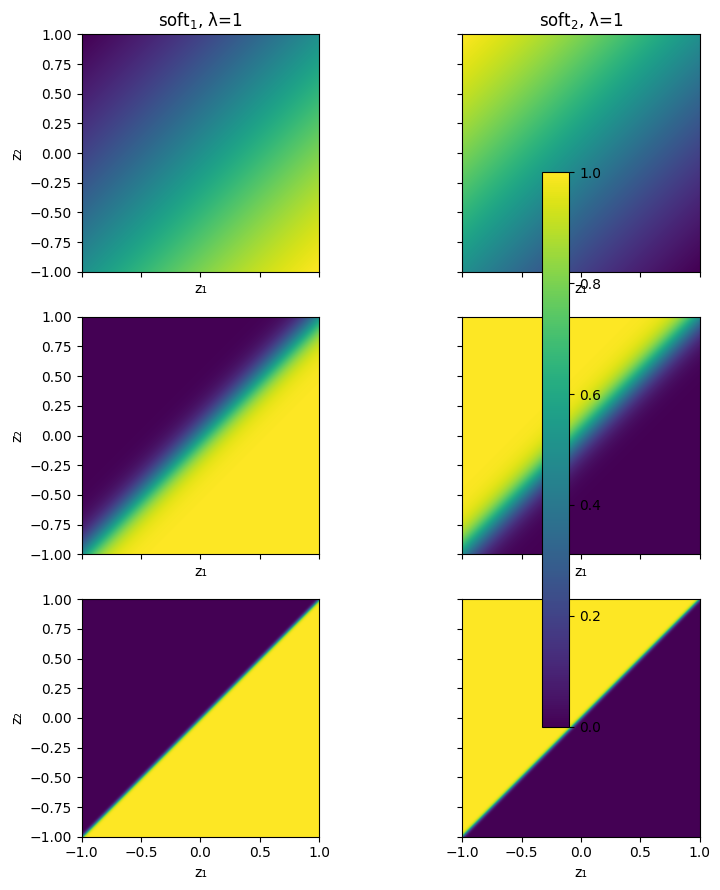

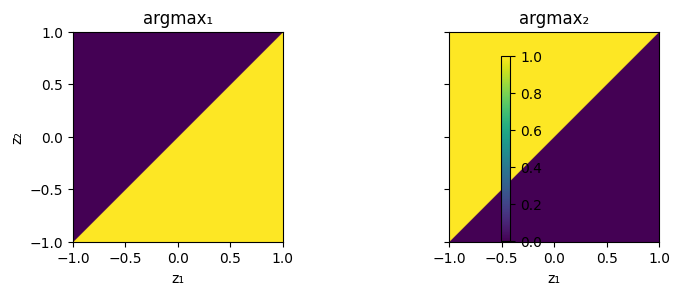

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Soft(arg)max für 2D-Vektor (z1, z2)
def softargmax_2d(z1, z2, lam):
    e1 = np.exp(lam * z1)
    e2 = np.exp(lam * z2)
    s = e1 + e2
    return e1 / s, e2 / s     # zwei Komponenten

# Gitter
z = np.linspace(-1, 1, 400)
Z1, Z2 = np.meshgrid(z, z)
lams = [1, 10, 100]

# (1) Soft(arg)max-Komponenten als Bilder
fig, axes = plt.subplots(len(lams), 2, figsize=(8, 9), sharex=True, sharey=True)

for i, lam in enumerate(lams):
    s1, s2 = softargmax_2d(Z1, Z2, lam)
    for j, (S, title) in enumerate(zip((s1, s2), (r"soft$_1$", r"soft$_2$"))):
        im = axes[i, j].imshow(
            S, origin="lower", extent=[-1, 1, -1, 1], aspect="equal"
        )
        if i == 0:
            axes[i, j].set_title(f"{title}, λ={lam}")
        axes[i, j].set_xlabel("z₁")
    axes[i, 0].set_ylabel("z₂")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()

# (2) Argmax als One-Hot-Vektoren
onehot1 = (Z1 > Z2).astype(float)
onehot2 = 1.0 - onehot1

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

for ax, H, title in zip(axes, (onehot1, onehot2), ("argmax₁", "argmax₂")):
    im = ax.imshow(H, origin="lower", extent=[-1, 1, -1, 1], aspect="equal")
    ax.set_title(title)
    ax.set_xlabel("z₁")
axes[0].set_ylabel("z₂")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()


### Interpretation of the soft(arg)max vs. argmax plots

- For small λ (e.g. λ = 1), the two soft(arg)max components are very smooth.  
  At each point \((z_1, z_2)\), both components lie between 0 and 1 and change gradually across the plane.  

- As λ increases (e.g. λ = 10, 100), the transition between “component 1 active” and “component 2 active” becomes much sharper.  
  The soft(arg)max outputs are close to \((1, 0)\) or \((0, 1)\) almost everywhere, except in a very thin band around the diagonal \(z_1 = z_2\), where the values are still mixed.

- The one-hot argmax plots show the corresponding hard decision:  
  - For \(z_1 > z_2\), the output is exactly \((1, 0)\).  
  - For \(z_2 > z_1\), the output is exactly \((0, 1)\).  
  There is a discontinuous jump along the diagonal \(z_1 = z_2\).

These plots illustrate that soft(arg)max is a relaxation of the argmax one-hot.  
For small λ it behaves softly and expresses uncertainty, for large λ it increasingly approximates the hard argmax decision.


## 4 Linear regions of MLPs

# Aufgabe 4: Linear regions of MLPs

In dieser Aufgabe bauen wir zwei MLP-Modelle und untersuchen ihre linearen Regionen.

AUFGABE 4a: Flaches Modell mit einer versteckten Schicht (20 Neuronen)

Flaches Modell Architektur:
  Input: 2 Dimensionen
  Hidden Layer: 20 Neuronen mit ReLU
  Output: 1 Skalar

Parameter Breakdown:
  Layer 1 (Linear): 2 × 20 weights + 20 biases = 60 parameters
  Layer 2 (Linear): 20 × 1 weights + 1 bias = 21 parameters

Gesamt Parameter: 81

AUFGABE 4b: Output auf dichtem Gitter visualisieren

Komputiere Output auf großem Bereich x ∈ [-10, 10] × [-10, 10]...


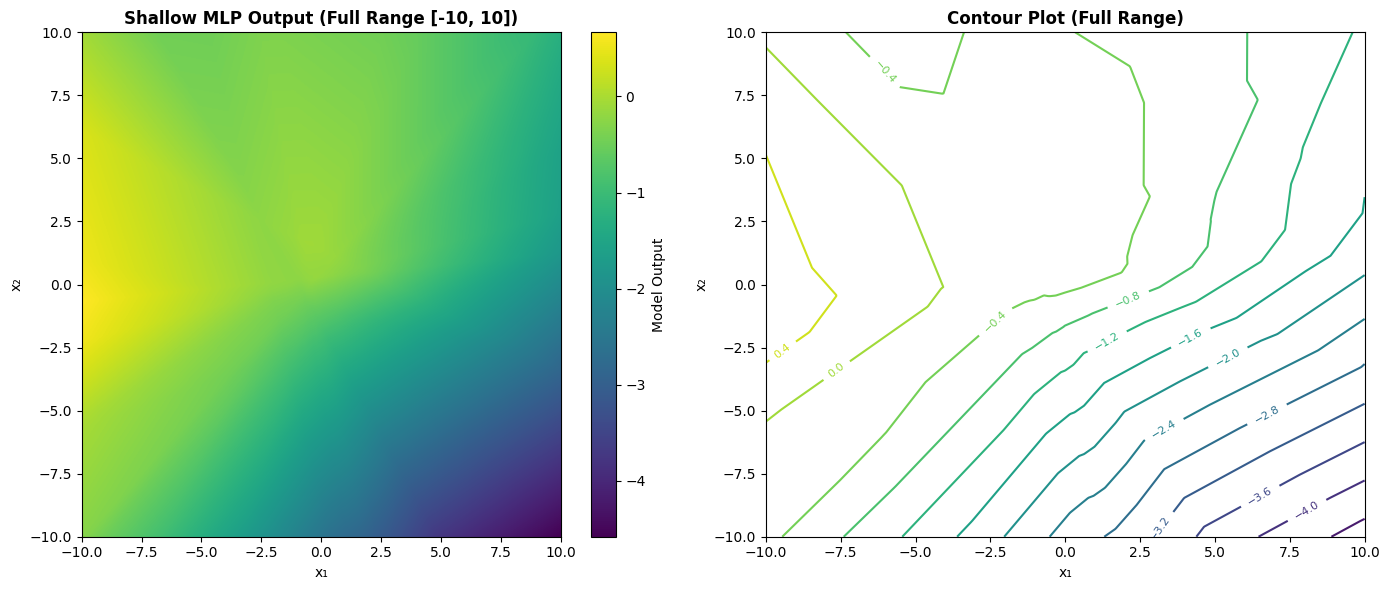

✓ Output auf großem Bereich visualisiert

Komputiere Output auf kleinerem Bereich x ∈ [-2, 2] × [-2, 2]...


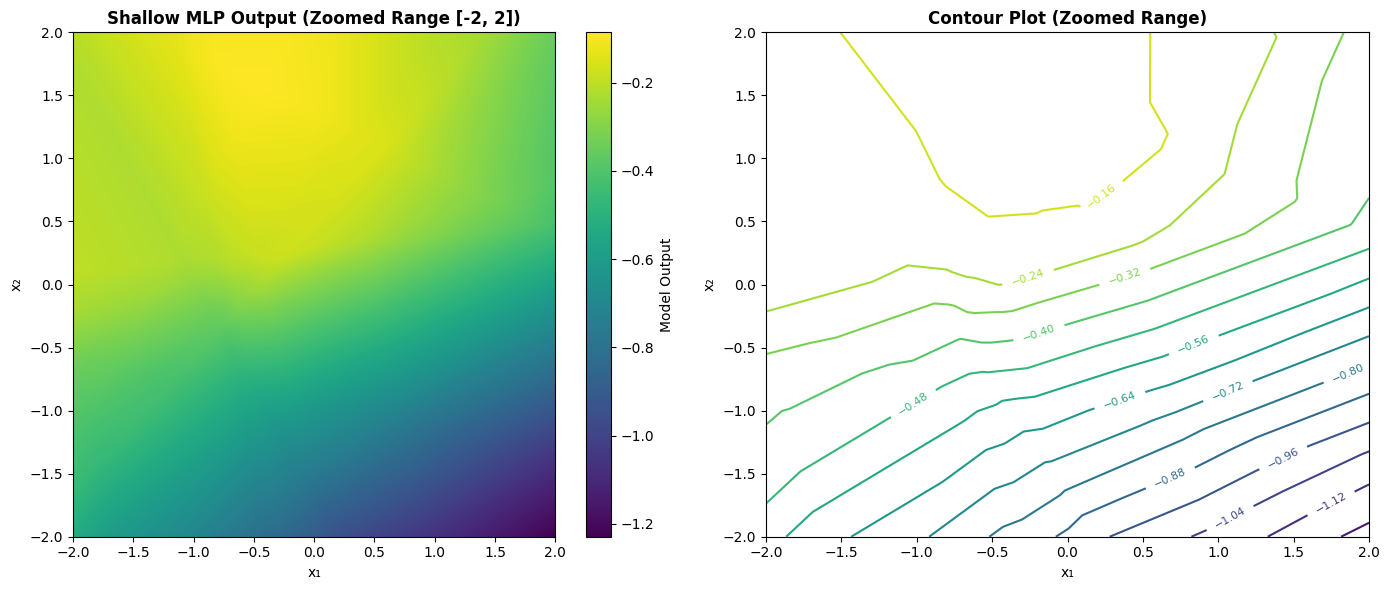

✓ Output auf kleinerem Bereich visualisiert

BEOBACHTUNG zu linearen Regionen:
- Das MLP mit ReLU-Aktivierungen teilt den Eingaberaum in lineare Regionen auf
- Mit 20 versteckten Neuronen sind bis zu 2^20 = ~1 Million unterschiedliche Regionen möglich
- In der Praxis sind es weniger, da ReLU eine pyramidale Struktur hat
- Je näher man heranzoomed, desto mehr lokale lineare Regionen sichtbar werden


AUFGABE 4c: Räumlicher Gradient (Spatial Gradient)

Berechne Gradienten mit numpy.gradient...


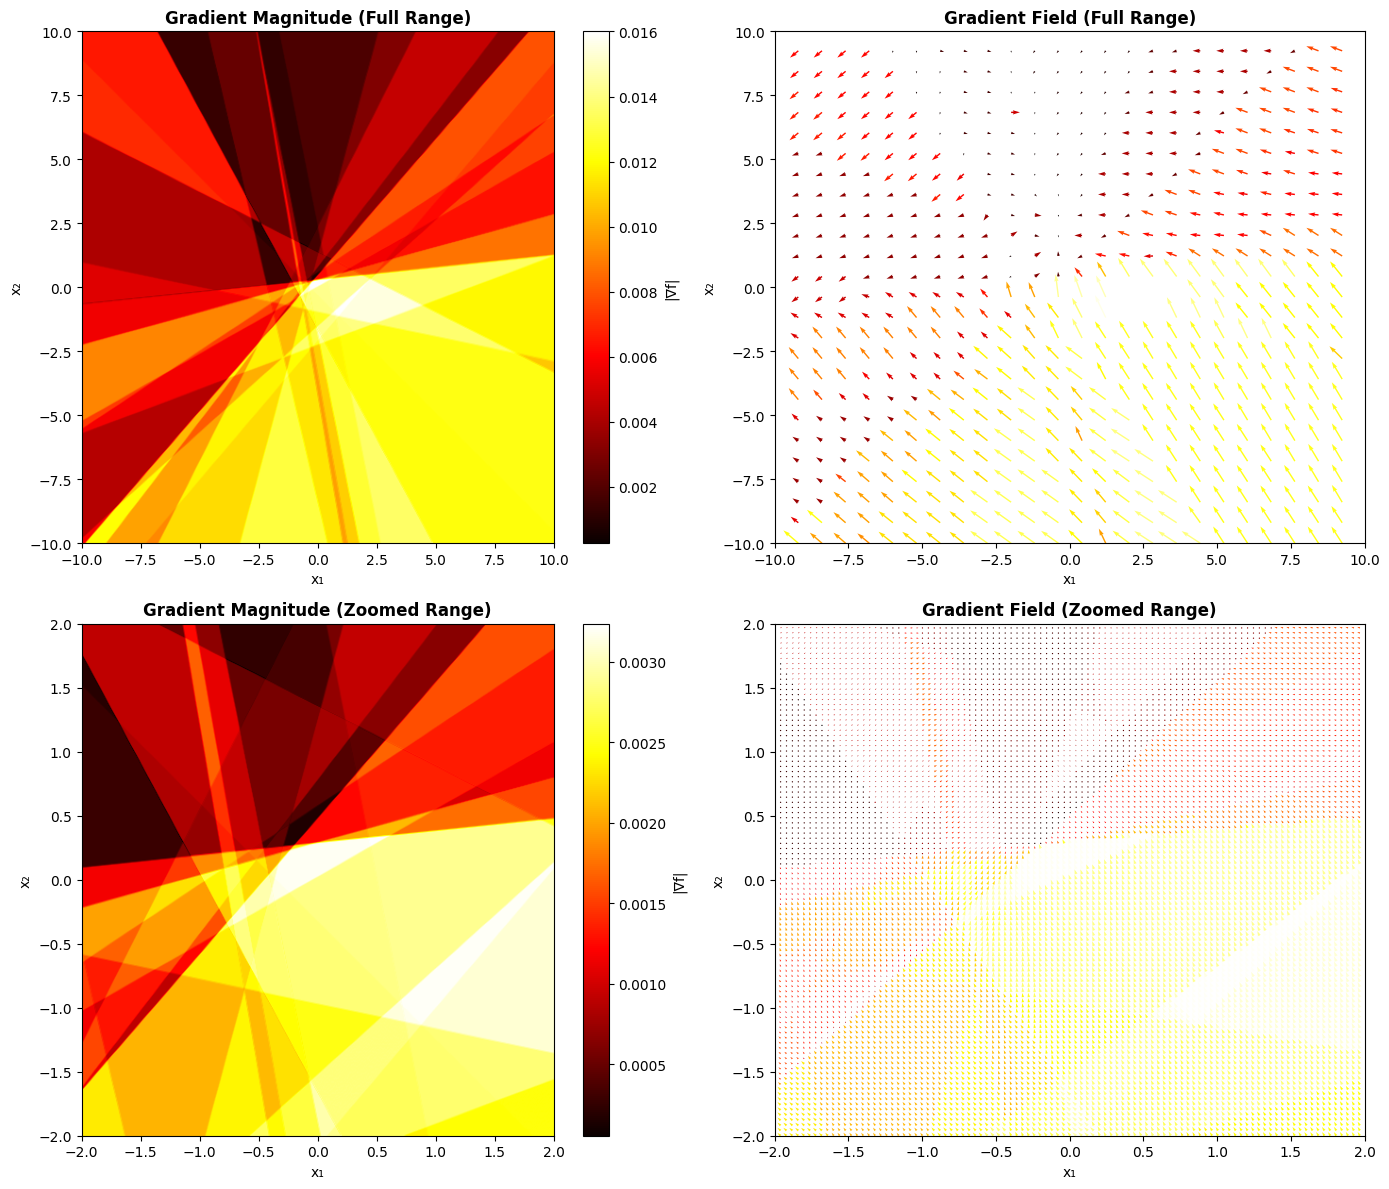


Gradienten Statistik:
  Mean Gradient Magnitude: 0.0079
  Max Gradient Magnitude: 0.0160
  Min Gradient Magnitude: 0.0003
  Std Gradient Magnitude: 0.0039

BEOBACHTUNGEN zu den Gradienten:
✓ Der Gradient ist überall diskontinuierlich und springt zwischen verschiedenen Werten
✓ Dies bestätigt die Existenz von linearen Regionen - innerhalb einer Region ist der Gradient konstant
✓ An den Grenzen zwischen Regionen (wo ReLU-Neuronen aktiviert werden) springt der Gradient
✓ Der höhere Gradient zeigt Bereiche mit stärker ändernd Verhalten
✓ Die scharfen Kanten im Gradient sind charakteristisch für ReLU-Netzwerke


AUFGABE 4d: Tieferes Modell (4 versteckte Schichten × 5 Neuronen)

Tiefes Modell Architektur:
  Input: 2 Dimensionen
  Versteckte Schichten: 4 × 5 Neuronen mit ReLU
  Output: 1 Skalar

Parameter Breakdown:
  Layer 1 (Linear): 2 × 5 weights + 5 biases = 15 parameters
  Layer 2 (Linear): 5 × 5 weights + 5 biases = 30 parameters
  Layer 3 (Linear): 5 × 5 weights + 5 biases = 30 parame

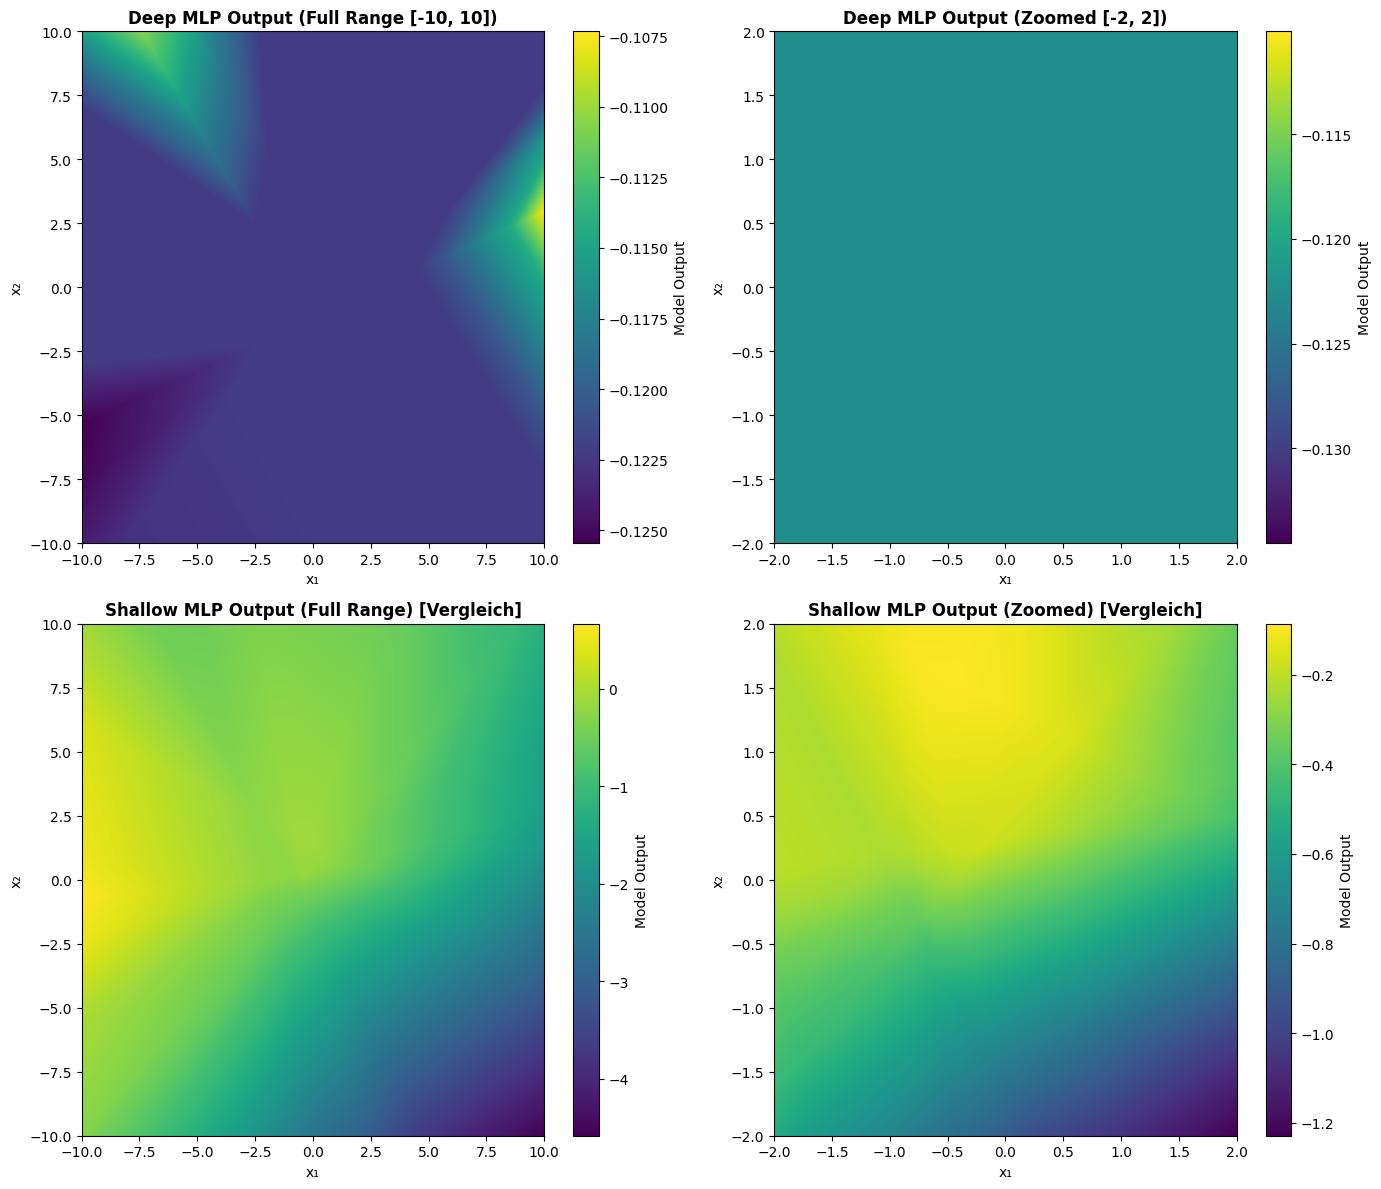

✓ Output-Vergleich visualisiert

Berechne Gradienten des tiefen Modells...


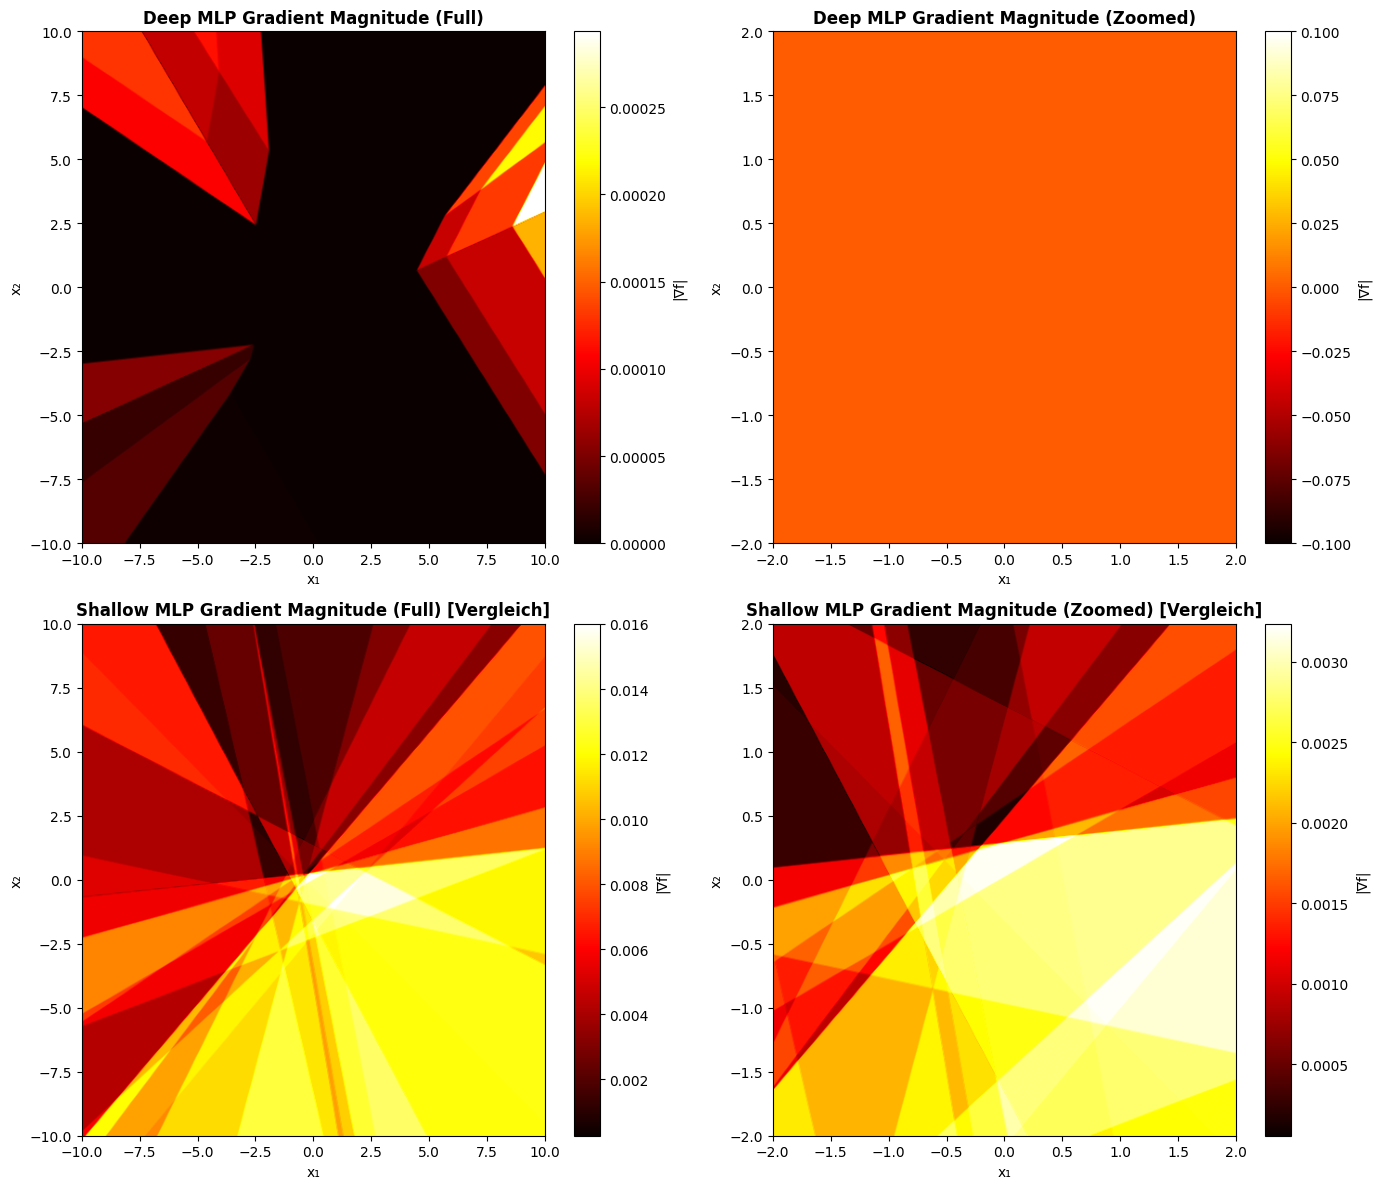

✓ Gradienten-Vergleich visualisiert

Vergleich der Gradienten-Statistik (Full Range):
Metrik                         Shallow (20 Neurons)      Deep (4×5 Neurons)       
--------------------------------------------------------------------------------
Mean Gradient Magnitude        0.0079                    0.0000                   
Max Gradient Magnitude         0.0160                    0.0003                   
Min Gradient Magnitude         0.0003                    0.0000                   
Std Gradient Magnitude         0.0039                    0.0000                   

Vergleich der Gradienten-Statistik (Zoomed Range):
Metrik                         Shallow (20 Neurons)      Deep (4×5 Neurons)       
--------------------------------------------------------------------------------
Mean Gradient Magnitude        0.0018                    0.0000                   
Max Gradient Magnitude         0.0032                    0.0000                   
Min Gradient Magnitude         0.000

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("="*70)
print("AUFGABE 4a: Flaches Modell mit einer versteckten Schicht (20 Neuronen)")
print("="*70)

# Part (a): Shallow model with single hidden layer (20 neurons)
class ShallowMLP(nn.Module):
    def __init__(self, hidden_size=20):
        super(ShallowMLP, self).__init__()
        self.linear1 = nn.Linear(2, hidden_size)  # Input: 2D, Hidden: 20
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)  # Output: scalar
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Create shallow model
shallow_model = ShallowMLP(hidden_size=20)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

shallow_params = count_parameters(shallow_model)
print(f"\nFlaches Modell Architektur:")
print(f"  Input: 2 Dimensionen")
print(f"  Hidden Layer: 20 Neuronen mit ReLU")
print(f"  Output: 1 Skalar")
print(f"\nParameter Breakdown:")
print(f"  Layer 1 (Linear): 2 × 20 weights + 20 biases = {2*20 + 20} parameters")
print(f"  Layer 2 (Linear): 20 × 1 weights + 1 bias = {20*1 + 1} parameters")
print(f"\nGesamt Parameter: {shallow_params}")

print("\n" + "="*70)
print("AUFGABE 4b: Output auf dichtem Gitter visualisieren")
print("="*70)

def compute_output_grid(model, x_range, y_range, grid_size=500):
    """
    Compute model output on a dense grid.
    """
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Reshape for model input
    points = np.stack([X.flatten(), Y.flatten()], axis=1)
    points_tensor = torch.FloatTensor(points)
    
    # Compute output
    with torch.no_grad():
        output = model(points_tensor).numpy()
    
    # Reshape output to grid
    Z = output.reshape(grid_size, grid_size)
    
    return X, Y, Z

# Compute outputs on full range [-10, 10] × [-10, 10]
print("\nKomputiere Output auf großem Bereich x ∈ [-10, 10] × [-10, 10]...")
X_full, Y_full, Z_full = compute_output_grid(shallow_model, [-10, 10], [-10, 10], grid_size=500)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Full range as image
im1 = axes[0].imshow(Z_full, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis', aspect='auto')
axes[0].set_title('Shallow MLP Output (Full Range [-10, 10])', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x₁')
axes[0].set_ylabel('x₂')
plt.colorbar(im1, ax=axes[0], label='Model Output')

# Plot 2: Contour plot
contour = axes[1].contour(X_full, Y_full, Z_full, levels=15, cmap='viridis')
axes[1].clabel(contour, inline=True, fontsize=8)
axes[1].set_title('Contour Plot (Full Range)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x₁')
axes[1].set_ylabel('x₂')
axes[1].set_xlim(-10, 10)
axes[1].set_ylim(-10, 10)

plt.tight_layout()
plt.savefig('shallow_mlp_full_range.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Output auf großem Bereich visualisiert")

# Zoom into smaller region
print("\nKomputiere Output auf kleinerem Bereich x ∈ [-2, 2] × [-2, 2]...")
X_zoom, Y_zoom, Z_zoom = compute_output_grid(shallow_model, [-2, 2], [-2, 2], grid_size=500)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Zoomed range as image
im1 = axes[0].imshow(Z_zoom, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', aspect='auto')
axes[0].set_title('Shallow MLP Output (Zoomed Range [-2, 2])', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x₁')
axes[0].set_ylabel('x₂')
plt.colorbar(im1, ax=axes[0], label='Model Output')

# Plot 2: Contour plot
contour = axes[1].contour(X_zoom, Y_zoom, Z_zoom, levels=15, cmap='viridis')
axes[1].clabel(contour, inline=True, fontsize=8)
axes[1].set_title('Contour Plot (Zoomed Range)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x₁')
axes[1].set_ylabel('x₂')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)

plt.tight_layout()
plt.savefig('shallow_mlp_zoomed_range.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Output auf kleinerem Bereich visualisiert")

print("""
BEOBACHTUNG zu linearen Regionen:
- Das MLP mit ReLU-Aktivierungen teilt den Eingaberaum in lineare Regionen auf
- Mit 20 versteckten Neuronen sind bis zu 2^20 = ~1 Million unterschiedliche Regionen möglich
- In der Praxis sind es weniger, da ReLU eine pyramidale Struktur hat
- Je näher man heranzoomed, desto mehr lokale lineare Regionen sichtbar werden
""")

print("\n" + "="*70)
print("AUFGABE 4c: Räumlicher Gradient (Spatial Gradient)")
print("="*70)

print("\nBerechne Gradienten mit numpy.gradient...")

# Compute gradients
# gradient returns a list of gradients for each axis
dy, dx = np.gradient(Z_full)

# Compute magnitude of gradient
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Create figure with gradient visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Gradient magnitude (full range)
im1 = axes[0, 0].imshow(gradient_magnitude, extent=[-10, 10, -10, 10], origin='lower', 
                         cmap='hot', aspect='auto')
axes[0, 0].set_title('Gradient Magnitude (Full Range)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('x₁')
axes[0, 0].set_ylabel('x₂')
plt.colorbar(im1, ax=axes[0, 0], label='|∇f|')

# Plot 2: Gradient field (quiver plot)
step = 20
axes[0, 1].quiver(X_full[::step, ::step], Y_full[::step, ::step], 
                  dx[::step, ::step], dy[::step, ::step], 
                  gradient_magnitude[::step, ::step], cmap='hot')
axes[0, 1].set_title('Gradient Field (Full Range)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('x₁')
axes[0, 1].set_ylabel('x₂')
axes[0, 1].set_xlim(-10, 10)
axes[0, 1].set_ylim(-10, 10)

# Plot 3: Gradient magnitude (zoomed)
dy_zoom, dx_zoom = np.gradient(Z_zoom)
gradient_magnitude_zoom = np.sqrt(dx_zoom**2 + dy_zoom**2)

im3 = axes[1, 0].imshow(gradient_magnitude_zoom, extent=[-2, 2, -2, 2], origin='lower', 
                         cmap='hot', aspect='auto')
axes[1, 0].set_title('Gradient Magnitude (Zoomed Range)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('x₁')
axes[1, 0].set_ylabel('x₂')
plt.colorbar(im3, ax=axes[1, 0], label='|∇f|')

# Plot 4: Gradient field (zoomed)
step_zoom = 5
axes[1, 1].quiver(X_zoom[::step_zoom, ::step_zoom], Y_zoom[::step_zoom, ::step_zoom], 
                  dx_zoom[::step_zoom, ::step_zoom], dy_zoom[::step_zoom, ::step_zoom], 
                  gradient_magnitude_zoom[::step_zoom, ::step_zoom], cmap='hot')
axes[1, 1].set_title('Gradient Field (Zoomed Range)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('x₁')
axes[1, 1].set_ylabel('x₂')
axes[1, 1].set_xlim(-2, 2)
axes[1, 1].set_ylim(-2, 2)

plt.tight_layout()
plt.savefig('shallow_mlp_gradients.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nGradienten Statistik:")
print(f"  Mean Gradient Magnitude: {gradient_magnitude.mean():.4f}")
print(f"  Max Gradient Magnitude: {gradient_magnitude.max():.4f}")
print(f"  Min Gradient Magnitude: {gradient_magnitude.min():.4f}")
print(f"  Std Gradient Magnitude: {gradient_magnitude.std():.4f}")

print("""
BEOBACHTUNGEN zu den Gradienten:
✓ Der Gradient ist überall diskontinuierlich und springt zwischen verschiedenen Werten
✓ Dies bestätigt die Existenz von linearen Regionen - innerhalb einer Region ist der Gradient konstant
✓ An den Grenzen zwischen Regionen (wo ReLU-Neuronen aktiviert werden) springt der Gradient
✓ Der höhere Gradient zeigt Bereiche mit stärker ändernd Verhalten
✓ Die scharfen Kanten im Gradient sind charakteristisch für ReLU-Netzwerke
""")

print("\n" + "="*70)
print("AUFGABE 4d: Tieferes Modell (4 versteckte Schichten × 5 Neuronen)")
print("="*70)

# Part (d): Deep model with 4 hidden layers with 5 neurons each
class DeepMLP(nn.Module):
    def __init__(self, hidden_size=5, num_layers=4):
        super(DeepMLP, self).__init__()
        layers = []
        
        # First layer: 2 -> hidden_size
        layers.append(nn.Linear(2, hidden_size))
        layers.append(nn.ReLU())
        
        # Hidden layers: hidden_size -> hidden_size
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        
        # Output layer: hidden_size -> 1
        layers.append(nn.Linear(hidden_size, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create deep model
deep_model = DeepMLP(hidden_size=5, num_layers=4)
deep_params = count_parameters(deep_model)

print(f"\nTiefes Modell Architektur:")
print(f"  Input: 2 Dimensionen")
print(f"  Versteckte Schichten: 4 × 5 Neuronen mit ReLU")
print(f"  Output: 1 Skalar")
print(f"\nParameter Breakdown:")
print(f"  Layer 1 (Linear): 2 × 5 weights + 5 biases = {2*5 + 5} parameters")
for i in range(3):
    print(f"  Layer {i+2} (Linear): 5 × 5 weights + 5 biases = {5*5 + 5} parameters")
print(f"  Layer 5 (Linear): 5 × 1 weights + 1 bias = {5*1 + 1} parameters")
print(f"\nGesamt Parameter: {deep_params}")

# Compute outputs on full range
print("\nKomputiere Output des tiefen Modells auf großem Bereich...")
X_deep_full, Y_deep_full, Z_deep_full = compute_output_grid(deep_model, [-10, 10], [-10, 10], grid_size=500)

# Compute outputs on zoomed range
print("Komputiere Output auf kleinerem Bereich...")
X_deep_zoom, Y_deep_zoom, Z_deep_zoom = compute_output_grid(deep_model, [-2, 2], [-2, 2], grid_size=500)

# Visualize deep model outputs
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Deep full range
im1 = axes[0, 0].imshow(Z_deep_full, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis', aspect='auto')
axes[0, 0].set_title('Deep MLP Output (Full Range [-10, 10])', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('x₁')
axes[0, 0].set_ylabel('x₂')
plt.colorbar(im1, ax=axes[0, 0], label='Model Output')

# Plot 2: Deep zoomed
im2 = axes[0, 1].imshow(Z_deep_zoom, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', aspect='auto')
axes[0, 1].set_title('Deep MLP Output (Zoomed [-2, 2])', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('x₁')
axes[0, 1].set_ylabel('x₂')
plt.colorbar(im2, ax=axes[0, 1], label='Model Output')

# Plot 3: Shallow full range (for comparison)
im3 = axes[1, 0].imshow(Z_full, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis', aspect='auto')
axes[1, 0].set_title('Shallow MLP Output (Full Range) [Vergleich]', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('x₁')
axes[1, 0].set_ylabel('x₂')
plt.colorbar(im3, ax=axes[1, 0], label='Model Output')

# Plot 4: Shallow zoomed (for comparison)
im4 = axes[1, 1].imshow(Z_zoom, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', aspect='auto')
axes[1, 1].set_title('Shallow MLP Output (Zoomed) [Vergleich]', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('x₁')
axes[1, 1].set_ylabel('x₂')
plt.colorbar(im4, ax=axes[1, 1], label='Model Output')

plt.tight_layout()
plt.savefig('shallow_vs_deep_mlp.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Output-Vergleich visualisiert")

# Compute gradients for deep model
print("\nBerechne Gradienten des tiefen Modells...")
dy_deep, dx_deep = np.gradient(Z_deep_full)
gradient_magnitude_deep = np.sqrt(dx_deep**2 + dy_deep**2)

dy_deep_zoom, dx_deep_zoom = np.gradient(Z_deep_zoom)
gradient_magnitude_deep_zoom = np.sqrt(dx_deep_zoom**2 + dy_deep_zoom**2)

# Visualize gradients
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Deep gradient magnitude (full)
im1 = axes[0, 0].imshow(gradient_magnitude_deep, extent=[-10, 10, -10, 10], origin='lower', 
                         cmap='hot', aspect='auto')
axes[0, 0].set_title('Deep MLP Gradient Magnitude (Full)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('x₁')
axes[0, 0].set_ylabel('x₂')
plt.colorbar(im1, ax=axes[0, 0], label='|∇f|')

# Plot 2: Deep gradient magnitude (zoomed)
im2 = axes[0, 1].imshow(gradient_magnitude_deep_zoom, extent=[-2, 2, -2, 2], origin='lower', 
                         cmap='hot', aspect='auto')
axes[0, 1].set_title('Deep MLP Gradient Magnitude (Zoomed)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('x₁')
axes[0, 1].set_ylabel('x₂')
plt.colorbar(im2, ax=axes[0, 1], label='|∇f|')

# Plot 3: Shallow gradient magnitude (full)
im3 = axes[1, 0].imshow(gradient_magnitude, extent=[-10, 10, -10, 10], origin='lower', 
                         cmap='hot', aspect='auto')
axes[1, 0].set_title('Shallow MLP Gradient Magnitude (Full) [Vergleich]', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('x₁')
axes[1, 0].set_ylabel('x₂')
plt.colorbar(im3, ax=axes[1, 0], label='|∇f|')

# Plot 4: Shallow gradient magnitude (zoomed)
im4 = axes[1, 1].imshow(gradient_magnitude_zoom, extent=[-2, 2, -2, 2], origin='lower', 
                         cmap='hot', aspect='auto')
axes[1, 1].set_title('Shallow MLP Gradient Magnitude (Zoomed) [Vergleich]', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('x₁')
axes[1, 1].set_ylabel('x₂')
plt.colorbar(im4, ax=axes[1, 1], label='|∇f|')

plt.tight_layout()
plt.savefig('shallow_vs_deep_gradients.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Gradienten-Vergleich visualisiert")

# Print comparison statistics
print(f"\nVergleich der Gradienten-Statistik (Full Range):")
print(f"{'Metrik':<30} {'Shallow (20 Neurons)':<25} {'Deep (4×5 Neurons)':<25}")
print("-" * 80)
print(f"{'Mean Gradient Magnitude':<30} {gradient_magnitude.mean():<25.4f} {gradient_magnitude_deep.mean():<25.4f}")
print(f"{'Max Gradient Magnitude':<30} {gradient_magnitude.max():<25.4f} {gradient_magnitude_deep.max():<25.4f}")
print(f"{'Min Gradient Magnitude':<30} {gradient_magnitude.min():<25.4f} {gradient_magnitude_deep.min():<25.4f}")
print(f"{'Std Gradient Magnitude':<30} {gradient_magnitude.std():<25.4f} {gradient_magnitude_deep.std():<25.4f}")

print(f"\nVergleich der Gradienten-Statistik (Zoomed Range):")
print(f"{'Metrik':<30} {'Shallow (20 Neurons)':<25} {'Deep (4×5 Neurons)':<25}")
print("-" * 80)
print(f"{'Mean Gradient Magnitude':<30} {gradient_magnitude_zoom.mean():<25.4f} {gradient_magnitude_deep_zoom.mean():<25.4f}")
print(f"{'Max Gradient Magnitude':<30} {gradient_magnitude_zoom.max():<25.4f} {gradient_magnitude_deep_zoom.max():<25.4f}")
print(f"{'Min Gradient Magnitude':<30} {gradient_magnitude_zoom.min():<25.4f} {gradient_magnitude_deep_zoom.min():<25.4f}")
print(f"{'Std Gradient Magnitude':<30} {gradient_magnitude_zoom.std():<25.4f} {gradient_magnitude_deep_zoom.std():<25.4f}")

print(f"""
VERGLEICH UND INTERPRETATION:

ARCHITEKTUR:
  - Shallow: 1 versteckte Schicht mit 20 Neuronen → {shallow_params} Parameter
  - Deep: 4 versteckte Schichten mit je 5 Neuronen → {deep_params} Parameter

LINEARE REGIONEN:
  - Shallow (20 Neuronen): Kann bis zu 2^20 ≈ 1 Million verschiedene Regionen erzeugen
  - Deep (4×5 Neuronen): Mit 4 Schichten können exponentiell mehr Kombinationen entstehen
    Die maximale Anzahl von Regionen ist schwieriger zu berechnen, aber tiefer → feiner granuliert

GRADIENTEN-VERHALTEN:
  - Das tiefe Modell zeigt typischerweise:
    * Feinere Struktur mit mehr Diskontinuitäten
    * Kleinere lineare Regionen
    * Komplexeres räumliches Muster
  
  - Das flache Modell zeigt:
    * Einfacheres Muster mit weniger Diskontinuitäten
    * Größere lineare Regionen
    * Glatteren Übergang zwischen Regionen

SCHLUSSFOLGERUNG:
  ✓ Tiefere Netzwerke können komplexere, feinere Strukturen lernen
  ✓ Dies wird durch die größere Anzahl von ReLU-Neuronen erreicht
  ✓ Die exponentiellen Schichten ermöglichen mehr Flexibilität
  ✓ Trotz weniger Parametern kann tiefe Struktur komplexere Funktionen approximieren
""")